# Initial Data Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train_data = pd.read_csv('train.csv')

In [4]:
train_data.shape

(762678, 61)

Our **training** data has 762,678 rows and 61 features

In [5]:
bond_ids = np.array(train_data.bond_id).tolist()

In [6]:
len(set(bond_ids))

3736

There are 3736 **unique** bond ids, in the training set.

In [7]:
test_data = pd.read_csv('test.csv')

In [9]:
test_data.shape

(61146, 59)

Our **testing** data has 61,146 rows and 59 features

**Test** data has 59 features, two less than training data. The dropped features are below

In [10]:
np.setdiff1d(np.array(train_data.columns), np.array(test_data.columns))

array(['bond_id', 'trade_price'], dtype=object)

In [11]:
null_arr = [train_data[col].isnull().sum() for col in train_data.columns]

In [12]:
sum(null_arr)

439351

In [13]:
train_data.curve_based_price_last10.isnull().sum()

17669

In [14]:
train_data.loc[0,'curve_based_price_last10']

nan

In [15]:
from scipy.stats import pearsonr
pearsonr(np.array(train_data['bond_id']), np.array(train_data['trade_price']))

(-0.20134247208985537, 0.0)

In [55]:
bond_id_dict = dict().fromkeys(set(bond_ids))

In [56]:
for i in range(len(train_data.index)):
    
    try:
        bond_id_dict[train_data.loc[i, 'bond_id']].append(train_data.loc[i, 'trade_price'])
    except:
        bond_id_dict[train_data.loc[i, 'bond_id']] = [train_data.loc[i, 'trade_price']]

In [57]:
for k in bond_id_dict.keys():
    bond_id_dict[k] = len(bond_id_dict[k])

Text(0.5,1,'noInstances vs Bond_id')

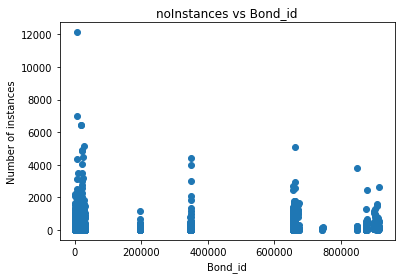

In [100]:
keys = list(bond_id_dict.keys())
lengths = list(bond_id_dict.values())

#plt.figure(figsize=(10,6))
plt.scatter(keys, lengths)
plt.xlabel("Bond_id")
plt.ylabel("Number of instances")
plt.title("noInstances vs Bond_id")

In [60]:
keys[np.argmax(lengths)]

6968

In [99]:
"""
for k in bond_id_dict.keys():
    bond_id_dict[k] = np.average(bond_id_dict[k])

keys = list(bond_id_dict.keys())
means = list(bond_id_dict.values())

plt.figure(figsize=(10,6))
plt.scatter(keys, means)
plt.xlabel("Bond_id")
plt.ylabel("Average trade_price")
plt.title("Average trade_price vs Bond_id")
"""

'\nfor k in bond_id_dict.keys():\n    bond_id_dict[k] = np.average(bond_id_dict[k])\n\nkeys = list(bond_id_dict.keys())\nmeans = list(bond_id_dict.values())\n\nplt.figure(figsize=(10,6))\nplt.scatter(keys, means)\nplt.xlabel("Bond_id")\nplt.ylabel("Average trade_price")\nplt.title("Average trade_price vs Bond_id")\n'

Let's try to fit an ARMA

In [81]:
non_zero_indices = np.nonzero(np.array(lengths) < 10)
len(non_zero_indices) == 0

False

From the above, there exists bond types that don't even have 10 instances. Let's identify which bond_ids are the ones w/out 10 instances

In [88]:
series = pd.Series.from_array(bond_id_dict)

In [94]:
bond_id_df = pd.DataFrame()
bond_id_df['lengths'] = series

In [119]:
bond_ids_gt10samples = np.array(bond_id_df[bond_id_df.lengths > 10].index)

In [112]:
len(set(bond_ids)) - len(bond_ids_gt10samples.tolist())

594

The above number indicates how many rows have been dropped due to an insufficient amount of samples to fit the ARMA

In [68]:
from statsmodels.tsa.arima_model import ARIMA

In [129]:
train_lt10_samples_dropped = train_data[train_data.bond_id.isin(bond_ids_gt10samples)]

In [130]:
len(train_data) - len(train_lt10_samples_dropped)

2987

The above number indicates the total number of rows dropped from the **training** data set due to an insufficient amount of samples to fit the ARMA

Let's store the row numbers corresponding to each bond_id 

In [187]:
corr_row_nums_dict = dict().fromkeys(set(bond_ids_gt10samples))
for bondID in set(train_lt10_samples_dropped.bond_id):
    
    all_rows = np.array(train_lt10_samples_dropped[train_lt10_samples_dropped.bond_id == bondID].index)
    corr_row_nums_dict[bondID] = all_rows   

In [164]:
np.random.seed(0)
## This will be good to prevent overfitting too?
def gen_random_subset(arr):
    
    return np.floor(np.random.uniform(0,len(arr), size=10))

In [188]:
subset_dict = dict().fromkeys(set(bond_ids))
for k in corr_row_nums_dict.keys():
    
    subset_dict[k] = np.random.choice(corr_row_nums_dict[k], size=10, replace=False)
    #print(type(corr_row_nums_dict[k]))

In [191]:
train_lt10_samples_dropped.head()

id  bond_id  trade_price     weight  current_coupon  time_to_maturity  \
0   1        1      128.596  11.316404            5.95         26.031126   
1   2        1      126.673   8.763446            5.95         26.016697   
2   3        1      126.880   6.499730            5.95         26.008760   
3   4        1      126.362   0.865854            5.95         26.008619   
4   5        1      124.918  11.938543            5.95         25.981840   

   is_callable  reporting_delay  trade_size  trade_type  \
0            0            1.731      120000           2   
1            0           30.518       85000           4   
2            0            4.424     4200000           3   
3            0           43.059     5000001           2   
4            0            6.332       10000           2   

             ...             received_time_diff_last9  trade_price_last9  \
0            ...                                  NaN                NaN   
1            ...                                  NaN                NaN   
2            ...                                  NaN                NaN   
3            ...                                  NaN                NaN   
4            ...                                  NaN                NaN   

   trade_size_last9  trade_type_last9  curve_based_price_last9  \
0               NaN               NaN                      NaN   
1               NaN               NaN                      NaN   
2               NaN               NaN                      NaN   
3               NaN               NaN                      NaN   
4               NaN               NaN                      NaN   

   received_time_diff_last10  trade_price_last10  trade_size_last10  \
0                        NaN                 NaN                NaN   
1                        NaN                 NaN                NaN   
2                        NaN                 NaN                NaN   
3                        NaN                 NaN                NaN   
4                        NaN                 NaN                NaN   

   trade_type_last10  curve_based_price_last10  
0                NaN                       NaN  
1                NaN                       NaN  
2                NaN                       NaN  
3                NaN                       NaN  
4                NaN                       NaN  

[5 rows x 61 columns]

In [ ]:
for idx in range(train_lt10_samples_dropped.index):
    train_lt10_samples_dropped.loc[idx, ]

Okay, I was thinking about this the wrong way. What I was thinking was: <br>

Suppose bond_id = 1 has 50 rows, randomly sample (w/out replacement) 10 of those rows fit an ARMA to each, and then average the coefficients to provide significant estimates. **However**, <br>

Notice that each row has 10 lagged periods, I think this is what the paper means by "estimate an ARMA(1,1) for 10 samples of each bond type" <br>

Hence, we should fit an ARMA for nearly every row, but grouping by bond_id. 

Let's drop any row that has an `NaN`

In [195]:
cleaned_train_lt10_samples_dropped = train_lt10_samples_dropped.dropna(axis=0)

In [197]:
len(train_lt10_samples_dropped) - len(cleaned_train_lt10_samples_dropped)

15204

We've dropped 15204 rows that contain NaN data, which would prevent us from fitting a 10 sample 